# Sports Dataset

10,000 random photos from soccer matches captured at a single timestamp make up the dataset. Every snapshot has a number of elements that offer details on the current match. The objective of the dataset is to capture the evolving dynamics of a soccer game, and to make predictions for the number of goals that will be scored for the remaining playing time.

# Dataset Structure

The dataset is presented in a single file with 10,000 rows and 20 columns, each row representing a snapshot of a soccer match, and each column representing a specific attribute or feature of that snapshot.

Number of Instances (Rows): 10,000 instances 
Number of Features (Columns): 20 features/columns 

# Feature Representation

The features include identifiers such as uuid, and dynamic match-related details such as the current minute of play, home and away team scores, yellow and red cards for both teams, the number of attacks and dangerous attacks by each team, corners awarded, shots on and off target for both teams, and the ball possession percentage for both the home and away teams until the current minute.

# Libraries

- pandas
- numpy
- matplotlib
- pickle
- os
- sklearn.metrics accuracy_score, classification_report, confusion_matrix
- sklearn.model_selection cross_val_predict, cross_val_score, train_test_split
- sklearn preprocessing 
- sklearn.linear_model LogisticRegression
- sklearn.model_selection GridSearchCV,train_test_split
- pytorch

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import seaborn as sns
import torch
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [163]:
df = pd.read_csv(filepath_or_buffer = 'sports.csv', header = 0)
df

,uuid,current_minute,home_score,away_score,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attacks,away_attacks,...,away_dangerous_attacks,home_corners,away_corners,home_off_target,away_off_target,home_on_target,away_on_target,home_possession,away_possession,final_delta
0,2f9dd904-8d9d-4aa0-a9d9-4e0f3e50d742,94,1,2,0,0,0,0,39,45,...,26,4,1,4,0,4,6,48,52,1
1,869c1420-9153-4d73-8d79-5db31a8a80a4,91,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,50,50,1
2,549e25a3-4c93-459d-b115-fb303273c78a,3,0,0,0,0,0,0,3,1,...,0,0,0,0,0,0,0,62,38,4
3,287b4be5-9163-4e2e-895d-d11052a97410,17,0,0,1,0,0,0,41,46,...,25,1,0,0,2,0,0,55,45,2
4,a607da6a-d6b2-4652-b7a5-6c8e4b61c2b8,76,1,0,1,0,0,0,69,78,...,46,1,1,0,3,4,4,45,55,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,838f35c5-afa3-474b-876e-063fd49d4326,32,0,0,0,0,0,0,16,25,...,13,0,1,1,2,0,1,45,55,0
6996,4bcfd248-5f39-4af2-b465-5358c9e7088e,101,3,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,50,50,0
6997,deccdc2c-625e-495a-9b06-02d540d4cd24,78,1,0,0,0,0,0,71,60,...,40,7,0,5,5,7,0,61,39,2
6998,94a20308-55d8-47cb-8f8b-d2702a531c74,72,2,0,0,0,0,0,85,66,...,20,3,0,4,1,2,1,52,48,0


# Data Preprocessing
Our objective for this project is to use the data given in the dataset to predict whether 1 or more goals can be scored in the remaining playing time of the match.

Remove Missing Data

In [4]:
df.dropna(inplace=True)

UUID is an unique identifier. no need to keep it.

In [5]:
try:
    df = df.drop(['uuid'], axis=1)
except:
    print('no uuid')

Use only data taken within the game time. Games last 105 minutes.  
Then remove any data from halftime. Halftime should be around minute 45 to minute 60. Because of that, starting minute 60, subtract them by 15 to make data contiguous.

In [6]:
df = df.query('0<= current_minute <= 105 ')
df = df.query('not (44 < current_minute <60)')
df['current_minute'] = df['current_minute'].apply(lambda x: x-15 if x > 45 else x)

<!-- df = df.groupby(df['current_minute'],as_index = False).aggregate('sum')
Aggregating was temptying but the samples became to small to use 
Feature Scaling
numerical_features = ['current_minute', 'home_score', 'away_score', 'home_yellow_cards', 'away_yellow_cards',
                      'home_red_cards', 'away_red_cards', 'home_attacks', 'away_attacks', 'home_dangerous_attacks',
                      'away_dangerous_attacks', 'home_corners', 'away_corners', 'home_off_target', 'away_off_target',
                      'home_on_target', 'away_on_target', 'home_possession', 'away_possession'] -->

In [7]:
# the target variable indicates whether 1 goal or more will be scored with the remaining time of the match. it shows binary values
df['target']= 0
df.loc[df['home_score'] + df['away_score']>0,'target'] = 1

X = df.drop(['target','home_score','away_score'], axis=1)
y = df['target']


In [8]:
# Current shape of our X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6577, 18)
Shape of y: (6577,)


# Exploratory Data Analysis

This is the content of the dataset

In [9]:
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,current_minute,home_score,away_score,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attacks,away_attacks,home_dangerous_attacks,...,home_corners,away_corners,home_off_target,away_off_target,home_on_target,away_on_target,home_possession,away_possession,final_delta,target
0,79,1,2,0,0,0,0,39,45,29,...,4,1,4,0,4,6,48,52,1,1
1,76,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,50,50,1,1
2,3,0,0,0,0,0,0,3,1,1,...,0,0,0,0,0,0,62,38,4,0
3,17,0,0,1,0,0,0,41,46,11,...,1,0,0,2,0,0,55,45,2,0
4,61,1,0,1,0,0,0,69,78,21,...,1,1,0,3,4,4,45,55,0,1


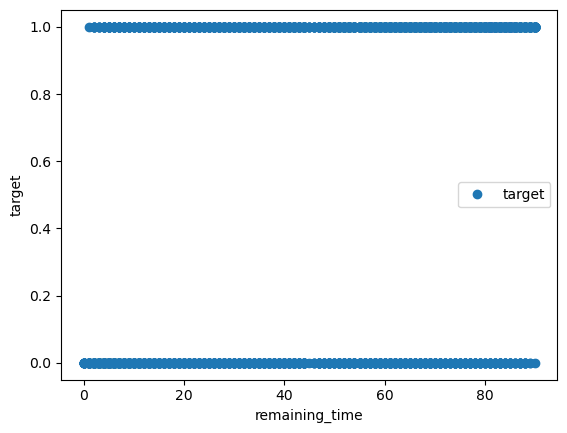

In [10]:
df.plot(x='current_minute', y='target', style='o')
plt.xlabel('remaining_time')
plt.ylabel('target')
plt.show()

Basic summary statistics for numerical values.  
Chart above shows that some snapshots had goals. Others had none. The data given does not have enough resolution to resolve when goals were made.

In [11]:
print("\nSummary statistics of numerical features:")
df.describe()


Summary statistics of numerical features:


,current_minute,home_score,away_score,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attacks,away_attacks,home_dangerous_attacks,...,home_corners,away_corners,home_off_target,away_off_target,home_on_target,away_on_target,home_possession,away_possession,final_delta,target
count,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,...,6577.00000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000
mean,49.804926,0.783032,0.608332,0.510263,0.592215,0.008515,0.014900,45.755968,42.857686,27.212863,...,2.33161,1.971111,3.016573,2.551163,2.136688,1.759313,51.581572,48.415235,1.427855,0.649536
std,26.441958,1.068046,0.911459,0.907488,1.007297,0.093528,0.122412,36.029737,33.539557,22.968335,...,2.44227,2.192337,3.138122,2.719920,2.316965,2.002735,10.542929,10.544736,1.423859,0.477151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,0.000000
25%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,13.000000,7.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000,42.000000,0.000000,0.000000
50%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.000000,40.000000,24.000000,...,2.00000,1.000000,2.000000,2.000000,2.000000,1.000000,51.000000,49.000000,1.000000,1.000000
75%,72.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,71.000000,67.000000,42.000000,...,4.00000,3.000000,5.000000,4.000000,3.000000,3.000000,58.000000,54.000000,2.000000,1.000000
max,90.000000,8.000000,9.000000,8.000000,8.000000,2.000000,2.000000,255.000000,183.000000,132.000000,...,14.00000,18.000000,24.000000,18.000000,22.000000,19.000000,100.000000,100.000000,10.000000,1.000000


Scatterplot matrix for pairs of numerical features


Pairplot for numerical features:


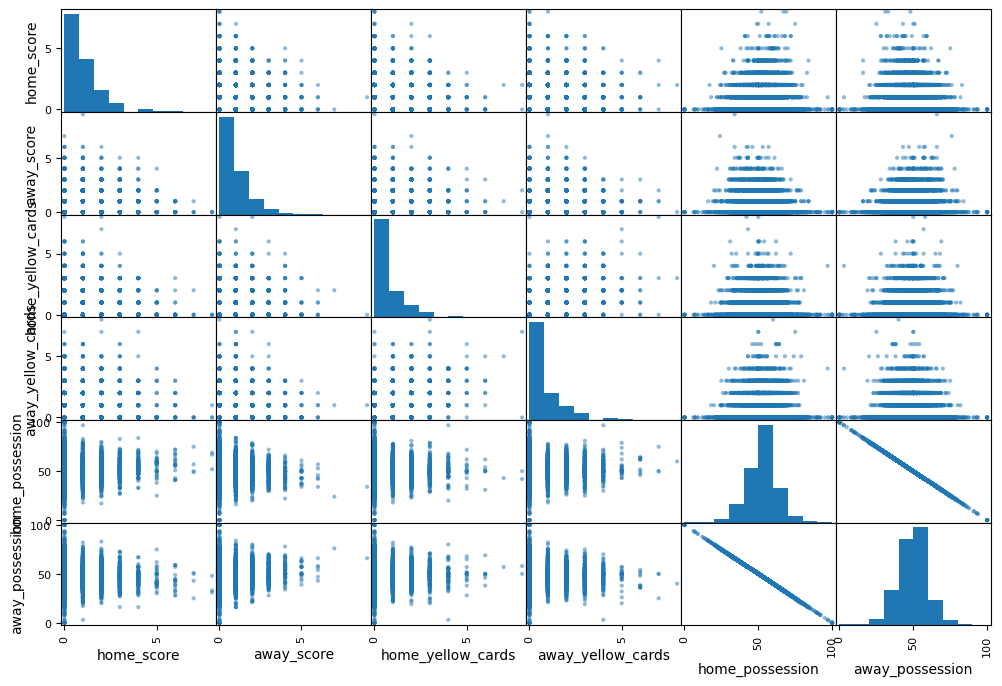

In [12]:
print("\nPairplot for numerical features:")
scatter_matrix = pd.plotting.scatter_matrix(df[['home_score', 'away_score', 'home_yellow_cards', 'away_yellow_cards', 'home_possession', 'away_possession']], figsize=(12, 8))
plt.show()

Histogram that shows the distribution of home and away scores


Distribution of home and away scores:


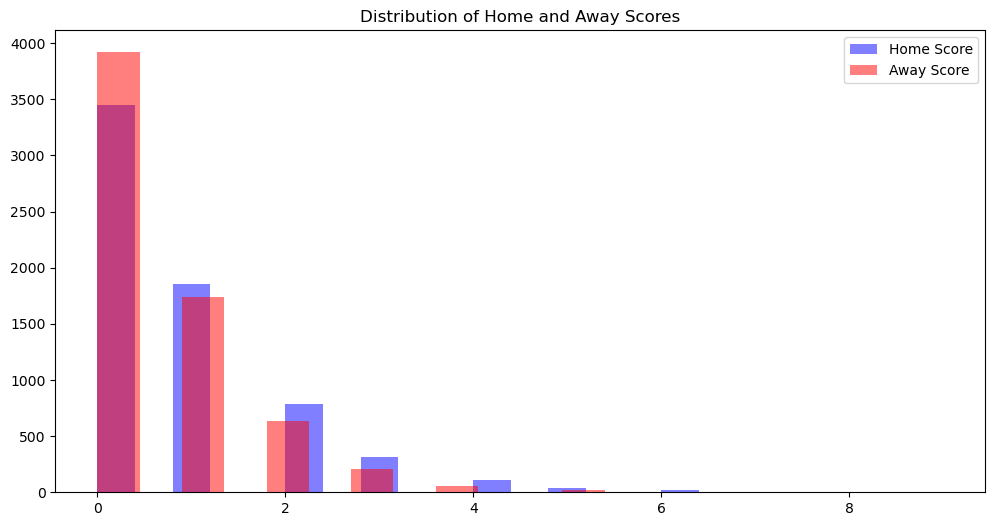

In [13]:
print("\nDistribution of home and away scores:")
plt.figure(figsize=(12, 6))
plt.hist(df['home_score'], bins=20, alpha=0.5, label='Home Score', color='blue')
plt.hist(df['away_score'], bins=20, alpha=0.5, label='Away Score', color='red')
plt.title('Distribution of Home and Away Scores')
plt.legend()
plt.show()

# Data set splitting

In [14]:
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Scale the data sets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# split train data to test and validation sets equally
# train data will train the initial  model
# validation will be used to find the best hyper parameters
X_train_1, X_val, y_train_1, y_val = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

# Helpers
The cells below contain functions that will help with displaying things later

In [15]:
# predictions: model predictions
# actual: the actual labels
#mode: type of data set evaluated
def show_metrics(true,predictions,mode = "Train"):
    
    accuracy = accuracy_score(true,predictions)
    conf_matrix = confusion_matrix(true,predictions)
    classification_rep = classification_report(true,predictions)
    
    print(f"\n{mode} Accuracy:", accuracy)
    print(f"{mode} Confusion Matrix:\n", conf_matrix)
    print(f"{mode} Classification Report:\n", classification_rep)
    return accuracy, conf_matrix,classification_rep

In [16]:
def show_mat(mat,title = "Confusion Matrix"):
    fig, axes = plt.subplots(1, 1, figsize=(12, 4))
    
    # Confusion Matrix
    sns.heatmap(mat, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes)
    axes.set_xlabel('Predicted')
    axes.set_ylabel('True')
    axes.set_title(title)
    
    plt.show()

# Logistic Regression Model
Since this is a classification task, Logistic regression can be applied. Its implementation is rather simple here.

Step 1: Initialize and train the model

In [17]:
logreg = LogisticRegression(n_jobs = -1)
logreg.fit(X_train_1,y_train_1)

LogisticRegression(n_jobs=-1)

Step 2: validate initial model


Train Accuracy: 0.8041825095057035
Train Confusion Matrix:
 [[263 112]
 [ 94 583]]
Train Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.70      0.72       375
           1       0.84      0.86      0.85       677

    accuracy                           0.80      1052
   macro avg       0.79      0.78      0.78      1052
weighted avg       0.80      0.80      0.80      1052



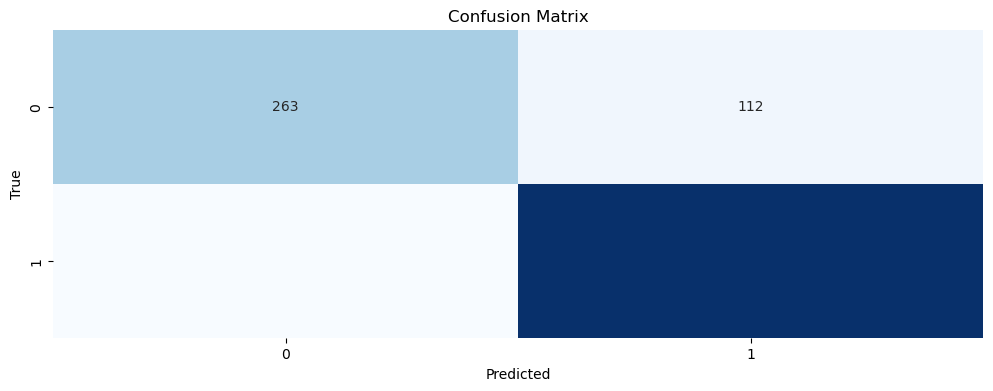

In [18]:
# This is the training 
metrics = show_metrics(y_train_1,logreg.predict(X_train_1))
show_mat(metrics[1])

Based on the class report, the model gives us approximately 80.42% accuracy of predictions for the train set. 

The confusion matrix gives us:
True Positives: 583
True Negatives: 263
False Positives: 112
False Negatives: 94

There is also a decent balance between the recall and precision for predicting whether one or more goals will be scored in the remaining time of a match.


Train Accuracy: 0.7963525835866262
Train Confusion Matrix:
 [[300 137]
 [131 748]]
Train Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.69      0.69       437
           1       0.85      0.85      0.85       879

    accuracy                           0.80      1316
   macro avg       0.77      0.77      0.77      1316
weighted avg       0.80      0.80      0.80      1316



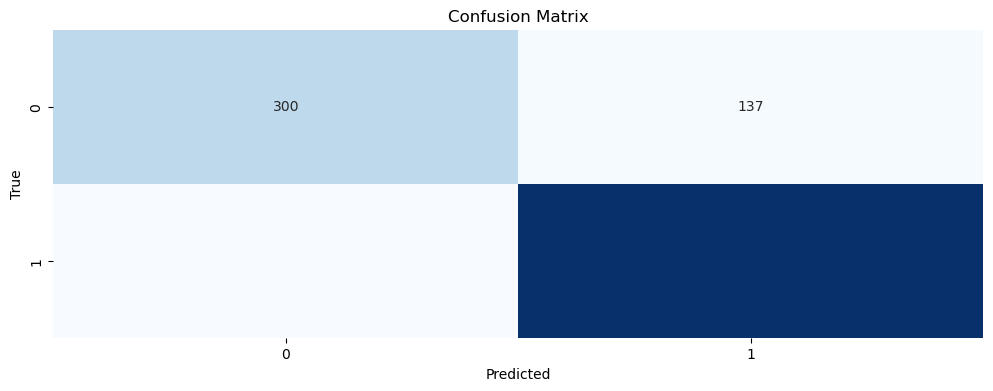

In [19]:
# get test accuracy with a validation set
test_pred = logreg.predict(X_test)
metrics = show_metrics(y_test,test_pred)
show_mat(metrics[1])


The accuracy on the validation set (79.64%) is slightly lower than the accuracy on the training set (80.42%). This model performed slightly lower on new, unseen data on the validation set. 

The confusion matrix gives us:
True Positives: 748
True Negatives: 300
False Positives: 137
False Negatives: 131

The confusion matrices show a similar pattern in terms of True Positives, True Negatives, False Positives, and False Negatives between the training and validation sets. Precision, recall, and F1-score for class (1) are also slightly consistent between the training and validation sets, indicating that the model's performance on predicting one or more goals is similar on both datasets.

Step 3: Find the best hyper parameters for the model

This is the grid of possible hyperparameter values to use. Dropped the solvers that use hessian matrix. Gridsearch practically did not finish. The regularization is only l2 because that is the only regularization function that all the solvers use. It is the default regularization. Regularization term C, tolerance, and the maximum iterations are only limited for demonstration purposes.

In [20]:
hpg = {'solver' : ['lbfgs', 'liblinear',  'sag','saga'],
      'fit_intercept' : [True,False],
       'class_weight' : [None, 'balanced'],
       'max_iter': [i for i in range(100,1000, 100)],
       'C' : [1.0,1.1,1.01,1.001,1.0001,1.00001],
       'tol' : [1e-5,1e-4,1e-3,1e-2,1e-1],
      }

Let the searching commence.

In [21]:
finder = GridSearchCV(logreg,hpg,n_jobs = -1,refit = True,scoring = 'f1',error_score='raise')

In [23]:
finder.fit(X_val, y_val)

GridSearchCV(error_score='raise', estimator=LogisticRegression(n_jobs=-1),
             n_jobs=-1,
             param_grid={'C': [1.0, 1.1, 1.01, 1.001, 1.0001, 1.00001],
                         'class_weight': [None, 'balanced'],
                         'fit_intercept': [True, False],
                         'max_iter': [100, 200, 300, 400, 500, 600, 700, 800,
                                      900],
                         'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
                         'tol': [1e-05, 0.0001, 0.001, 0.01, 0.1]},
             scoring='f1')

In [24]:
logreg = finder.best_estimator_

To evaluate the model, we will get the training accuracy first. We used the validation set for training since the Training dataset was already used to train the initial model.


Train Accuracy: 0.7823711095272036
Train Confusion Matrix:
 [[ 989  504]
 [ 412 2304]]
Train Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.66      0.68      1493
           1       0.82      0.85      0.83      2716

    accuracy                           0.78      4209
   macro avg       0.76      0.76      0.76      4209
weighted avg       0.78      0.78      0.78      4209



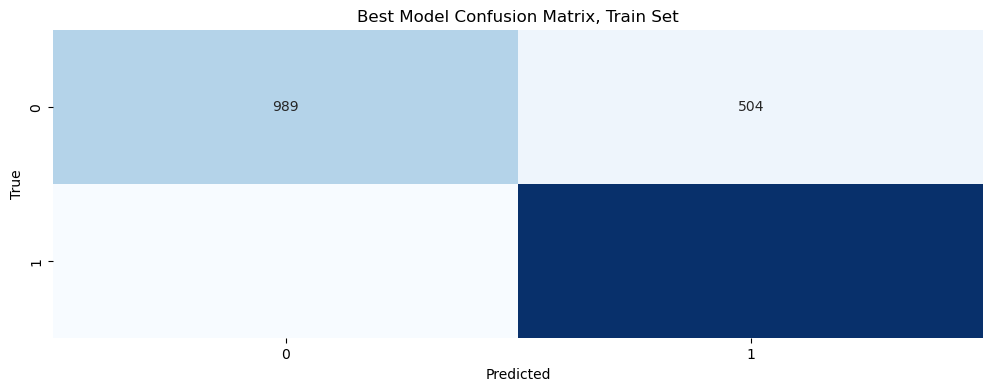

In [25]:
train_predictions = logreg.predict(X_val)
acc, mat, class_rep = show_metrics(y_val,train_predictions,"Train")
show_mat(mat,"Best Model Confusion Matrix, Train Set")

The accuracy slightly decreased after hyperparameter tuning, going from 80.42% to 78.24%. This could be due to the model being more conservative after tuning.

There is a notable increase in both true positives (TP) and true negatives (TN) after hyperparameter tuning. However, false positives (FP) and false negatives (FN) have also increased.

The precision for class 1 remained the same, but recall and f1-score slightly decreased. This indicates that the model is still good at identifying instances of class 1, though there is still a chance that it does not capture some data points.

After evaluating the model on the validation set, we will now evaluate it on the test set to see how well it can predict on its own.

In [26]:
# Make predictions on the test setn
test_predictions = logreg.predict(X_test)


Train Accuracy: 0.7963525835866262
Train Confusion Matrix:
 [[301 136]
 [132 747]]
Train Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.69      0.69       437
           1       0.85      0.85      0.85       879

    accuracy                           0.80      1316
   macro avg       0.77      0.77      0.77      1316
weighted avg       0.80      0.80      0.80      1316



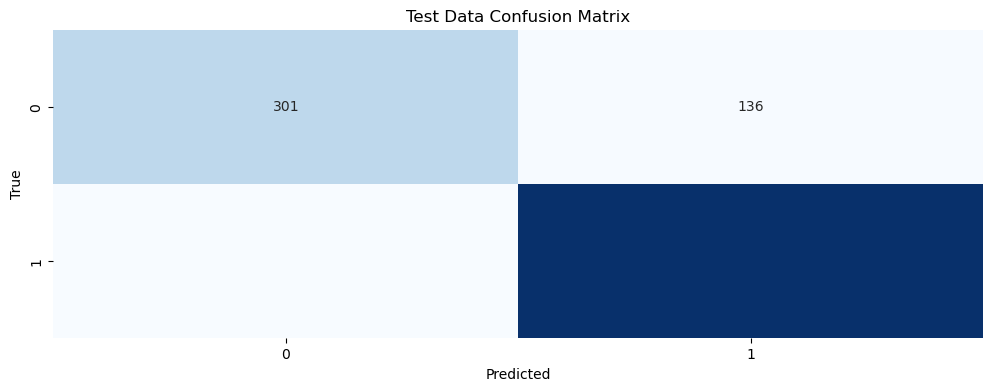

In [27]:
# Evaluate the model on the test set
metrics = show_metrics(y_test,test_predictions)
show_mat(metrics[1], "Test Data Confusion Matrix")

We can see that the accuracy on the test set (79.64%) is very close to the accuracy on the training set (78.24%). This suggests that the model is generalizing well to new, unseen data.

The true positives (TP) and true negatives (TN) on the test set are similar to those on the training set. False positives (FP) and false negatives (FN) also exhibit similar patterns.

The precision, recall, and f1-score for both classes (0 and 1) are consistent between the test and training sets. This indicates that the model's performance is stable across the two datasets.

# Logistic Regression Model Conclusions

After hyperparameter tuning, the test set performance is similar to the training set performance, suggesting that the model generalizes well to the test set. The hyperparameter-tuned model appears to be robust and not overfit to the training data based on the consistency of metrics between the training and test sets.

# Neural Network Model

Next, let's create a neural network model for our predictions.

In [164]:
# preparing data for pytorch
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Convert the training, validation, and test data into PyTorch tensors, to enable compatibility with PyTorch neural network models.

In [165]:
# convert data to pytorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

Let's make sure to involve the creation of PyTorch datasets and dataloaders. The following code block utilizes TensorDataset to bundle the input features and target variables into training, validation, and test datasets. Moreover, DataLoader is employed to handle batch processing during model training, validation, and testing.

In [166]:
# create pytorch datasets and dataloaders
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

Next, let's define a neural network class using PyTorch's nn.Module. The network will consist of two fully connected layers  with a ReLU activation function applied after the first layer.

In [167]:
# defining the neural network
class RegressionNN(nn.Module):
    def __init__(self, input_size):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Initialize the neural network model by instantiating it with the input size corresponding to the number of features in the training data. Also, don't forget to initialize the hyperparameters by setting up the mean squared error loss function and the Adam optimizer with a learning rate of 0.001, to enable the training of the neural network for regression tasks.

In [168]:
# instantiate the model, loss function and optimizer
input_size = X_train.shape[1]
model = RegressionNN(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Let's train the model! For now, we'll use the hyperparameters: epochs = 50, learning rate = 0.001 and batch size = 32.

In [169]:
# model training
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, targets in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, targets)

Let's evaluate the model before seeking out the best parameters to use, how well did we do? (Note: since we are using a Neural Network for a regression task, we'll use MSE to measure loss)

In [170]:
# evaluation (training set)
model.eval()
predictions = []
targets_list = []
with torch.no_grad():
    for inputs, targets in train_loader:
        outputs = model(inputs)
        predictions.extend(outputs.numpy())
        targets_list.extend(targets.numpy())

test_mse = mean_squared_error(targets_list, predictions)
print(f'Test MSE: {test_mse}')

Test MSE: 0.12549705803394318



Train Accuracy: 0.8122623574144486
Train Confusion Matrix:
 [[ 963  542]
 [ 248 2455]]
Train Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.64      0.71      1505
         1.0       0.82      0.91      0.86      2703

    accuracy                           0.81      4208
   macro avg       0.81      0.77      0.79      4208
weighted avg       0.81      0.81      0.81      4208



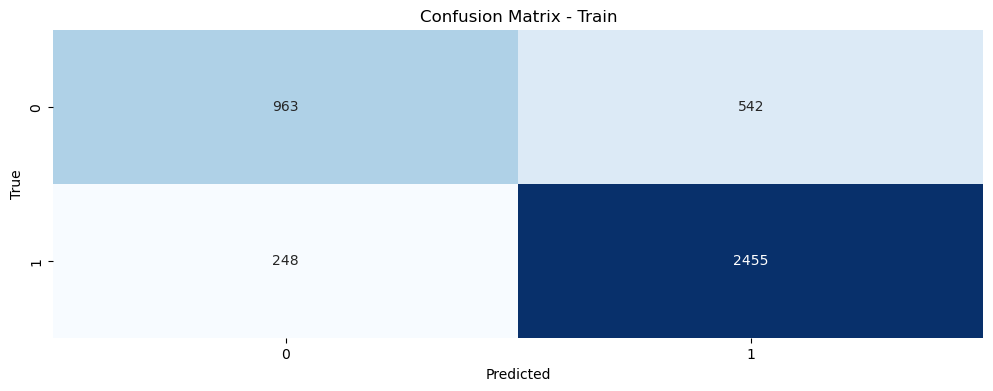

In [171]:
show_metrics(targets_list, np.round(predictions), mode="Train")
conf_matrix_train = confusion_matrix(targets_list, np.round(predictions))
show_mat(conf_matrix_train, title="Confusion Matrix - Train")

To find the best hyperparameters, let's perform manual hyperparameter tuning. The following code iterates through different combinations of learning rates (lr), batch sizes (batch_size), and epochs (epochs). For each combination, it trains the model using the training data and evaluates its performance on the validation set. The best hyperparameters are determined based on the lowest mean squared error (MSE) on the test set, and the corresponding best model is retained.

In [160]:
# hyperparameter tuning
best_mse = float('inf')
best_params = None

for lr in [0.001, 0.01, 0.1]:
    for batch_size in [32, 64]:
        for epochs in [50, 100]:
            model = RegressionNN(X_train.shape[1])
            optimizer = optim.Adam(model.parameters(), lr=lr)
            criterion = nn.MSELoss()

            train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_data, batch_size=batch_size)

            for epoch in range(epochs):
                model.train()
                for inputs, targets in train_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    loss.backward()
                    optimizer.step()

                model.eval()
                with torch.no_grad():
                    val_loss = 0.0
                    for inputs, targets in val_loader:
                        outputs = model(inputs)
                        val_loss += criterion(outputs, targets)

                val_mse = val_loss / len(val_loader)

            model.eval()
            predictions = []
            targets_list = []
            with torch.no_grad():
                for inputs, targets in DataLoader(test_data, batch_size=batch_size):
                    outputs = model(inputs)
                    predictions.extend(outputs.numpy())
                    targets_list.extend(targets.numpy())

            test_mse = mean_squared_error(targets_list, predictions)
            print(f'LR: {lr}, Batch Size: {batch_size}, Epoch {epochs}, Test MSE: {test_mse}')

            if test_mse < best_mse:
                best_mse = test_mse
                best_params = {'lr': lr, 'batch_size': batch_size, 'epochs': epochs}
                best_model = model

print("Best Hyperparameters:", best_params)

LR: 0.001, Batch Size: 32, Epoch 50, Test MSE: 0.13793785870075226
LR: 0.001, Batch Size: 32, Epoch 100, Test MSE: 0.14577074348926544
LR: 0.001, Batch Size: 64, Epoch 50, Test MSE: 0.13791513442993164
LR: 0.001, Batch Size: 64, Epoch 100, Test MSE: 0.14161191880702972
LR: 0.01, Batch Size: 32, Epoch 50, Test MSE: 0.14426426589488983
LR: 0.01, Batch Size: 32, Epoch 100, Test MSE: 0.14349237084388733
LR: 0.01, Batch Size: 64, Epoch 50, Test MSE: 0.13809651136398315
LR: 0.01, Batch Size: 64, Epoch 100, Test MSE: 0.1516948640346527
LR: 0.1, Batch Size: 32, Epoch 50, Test MSE: 0.14148686826229095
LR: 0.1, Batch Size: 32, Epoch 100, Test MSE: 0.15089450776576996
LR: 0.1, Batch Size: 64, Epoch 50, Test MSE: 0.14622946083545685
LR: 0.1, Batch Size: 64, Epoch 100, Test MSE: 0.1407519429922104
Best Hyperparameters: {'lr': 0.001, 'batch_size': 64, 'epochs': 50}


From the results of our exhaustive search, we can see that the MSEs for the hyperparameter combinations are around 13-15%. The best performing hyperparameter combination is learning rate = 0.001, batch size = 64, and epochs = 50.

Let's evaluate our best model.

In [176]:
# evaluation (training set - best model)
best_model.eval()
predictions = []
targets_list = []
with torch.no_grad():
    for inputs, targets in train_loader:
        outputs = best_model(inputs)
        predictions.extend(outputs.numpy())
        targets_list.extend(targets.numpy())

train_mse = mean_squared_error(targets_list, predictions)
print(f'Train MSE: {train_mse}')

Train MSE: 0.13036750257015228



Train Accuracy: 0.8127376425855514
Train Confusion Matrix:
 [[1008  497]
 [ 291 2412]]
Train Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.67      0.72      1505
         1.0       0.83      0.89      0.86      2703

    accuracy                           0.81      4208
   macro avg       0.80      0.78      0.79      4208
weighted avg       0.81      0.81      0.81      4208



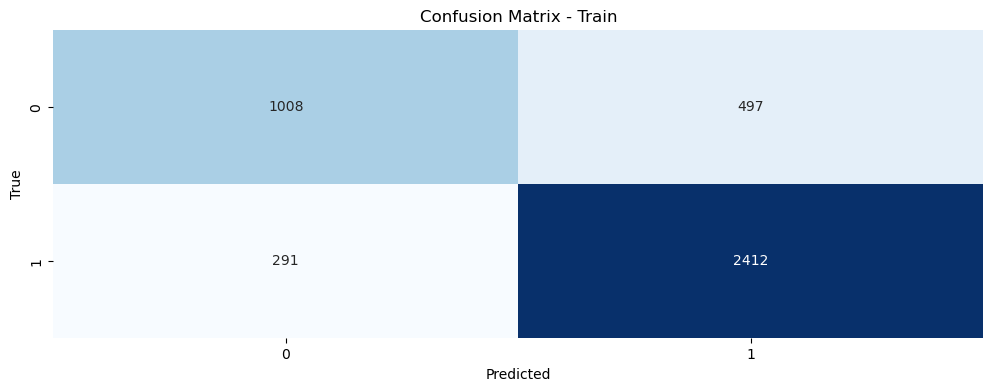

In [177]:
show_metrics(targets_list, np.round(predictions), mode="Train")
conf_matrix_train = confusion_matrix(targets_list, np.round(predictions))
show_mat(conf_matrix_train, title="Confusion Matrix - Train")

From the classification report, we can see that the best model shows marginal improvement in accuracy over the initial model.

In [174]:
# evaluation (test set - best model)
best_model.eval()
predictions = []
targets_list = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = best_model(inputs)
        predictions.extend(outputs.numpy())
        targets_list.extend(targets.numpy())

test_mse = mean_squared_error(targets_list, predictions)
print(f'Test MSE: {test_mse}')

Test MSE: 0.13791513442993164



Test Accuracy: 0.7986322188449848
Test Confusion Matrix:
 [[286 151]
 [114 765]]
Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.65      0.68       437
         1.0       0.84      0.87      0.85       879

    accuracy                           0.80      1316
   macro avg       0.78      0.76      0.77      1316
weighted avg       0.80      0.80      0.80      1316



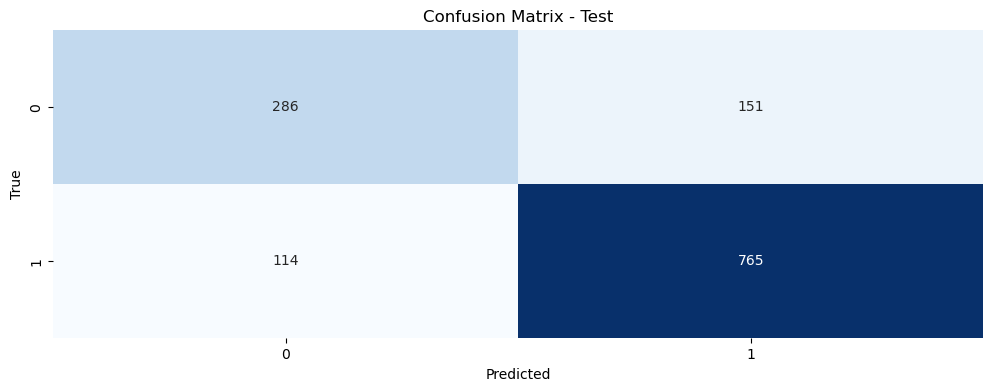

In [175]:
show_metrics(targets_list, np.round(predictions), mode="Test")
conf_matrix_test = confusion_matrix(targets_list, np.round(predictions))
show_mat(conf_matrix_test, title="Confusion Matrix - Test")

We can see from the report that the accuracy of the best model on the test set is around 79.86%, which is close to the results of the model on the training set (81.27%).

# Neural Network Conclusion

In conclusion, the created neural network with the best hyperparameters does a good job with new data, demonstrating its effectiveness in predicting the number of goals in the remaining playing time of soccer matches. The model underwent a comprehensive training process, incorporating hyperparameter tuning to enhance its performance. 